# **Recommendation System: Anime**
- **Nama:** Muhammad Azhar Fikri
- **Email:** muhammadazharfikri990@gmail.com
- **ID Dicoding:** ririee



![yn](https://i.pinimg.com/originals/31/63/4d/31634d375e820ae99a57147445387833.gif)

# **1. Import Library**

Pada tahap ini, mengimpor beberapa pustaka (library) Python yang dibutuhkan untuk analisis data dan pembangunan model machine learning.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

from collections import Counter

import re
import html
import random
import warnings
warnings.filterwarnings('ignore')

import zipfile
from google.colab import files

# **2. Data Loading**

Memuat dataset dari Kaggle yakni Dataset `anime-recommendations-database` yang diupload oleh **CooperUnion**.

In [2]:
files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [3]:
!kaggle datasets download -d CooperUnion/anime-recommendations-database

Dataset URL: https://www.kaggle.com/datasets/CooperUnion/anime-recommendations-database
License(s): CC0-1.0
anime-recommendations-database.zip: Skipping, found more recently modified local copy (use --force to force download)


Selanjutnya, mengekstrak file zip.

In [4]:
zip_ref = zipfile.ZipFile('/content/anime-recommendations-database.zip', 'r')
zip_ref.extractall('/content/')
zip_ref.close()

Dataset format `.csv` disimpan pada variabel dataframe `anime` dan `rating`

In [5]:
anime = pd.read_csv('anime.csv')
rating = pd.read_csv('rating.csv')

# **3. Data Understanding**

Data yang digunakan berasal dari dua file `.csv` yaitu `anime.csv` dan `rating.csv`

## **Dataset Anime**
Dataset ini berisi informasi tentang berbagai anime. Terdapat **12.294 entri** dalam dataset ini, dengan kolom-kolom sebagai berikut:
- **anime_id**: ID unik untuk setiap anime.
- **name**: Nama anime.
- **genre**: Genre atau kategori anime.
- **type**: Jenis anime.
- **episodes**: Jumlah episode yang tersedia untuk anime tersebut.
- **rating**: Rating rata-rata dari anime.
- **members**: Jumlah anggota yang menilai atau terdaftar pada anime tersebut.

In [6]:
anime.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [7]:
anime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


In [8]:
for i, (column_name, all_item) in enumerate(anime.count().items(), 1):
    print(f"kolom {i:2d}: {column_name} - total:  {all_item}")

kolom  1: anime_id - total:  12294
kolom  2: name - total:  12294
kolom  3: genre - total:  12232
kolom  4: type - total:  12269
kolom  5: episodes - total:  12294
kolom  6: rating - total:  12064
kolom  7: members - total:  12294


In [9]:
print(f'{anime.shape[0]} baris dan {anime.shape[1]} kolom.')

12294 baris dan 7 kolom.


Dataset ini memiliki beberapa nilai yang kosong pada kolom **genre** (62 nilai kosong), **type** (25 nilai kosong), dan **rating** (230 nilai kosong).


In [10]:
anime.isnull().sum()

,0
anime_id,0
name,0
genre,62
type,25
episodes,0
rating,230
members,0


In [11]:
anime.duplicated().sum()

np.int64(0)

**Fitur Kategorikal (Categorical Features)**  
Fitur kategorikal biasanya berisi nilai-nilai yang dikelompokkan dalam kategori tertentu. Dari dataset yang tersedia, fitur yang tergolong kategorikal adalah:
- **name** (`object`) – Nama anime.
- **genre** (`object`) – Genre atau kategori anime.
- **type** (`object`) – Jenis anime (misalnya, TV, Movie, OVA, dll).
- **episodes** (`object`) – Jumlah episode

**Fitur Numerik (Numerical Features)**  
Fitur numerik mengandung nilai yang berupa angka. Fitur-fitur numerik dalam dataset ini adalah:
- **anime_id** (`int64`) – ID unik untuk setiap anime.
- **rating** (`float64`) – Rating rata-rata dari anime.
- **members** (`int64`) – Jumlah anggota yang menilai atau terdaftar pada anime tersebut.

**Kesimpulan**  
Dari analisis tipe data, dapat disimpulkan bahwa:
- Terdapat **4** fitur kategorikal yang berbentuk string (`object`), yaitu `name`, `genre`, `type`, dan `episodes`.
- Terdapat **3** fitur numerik, yaitu `anime_id`, `rating`, dan `members`. Fitur numerik ini terdiri dari dua tipe data: `integer` (`anime_id`, `members`) dan `float` (`rating`).

## **Dataset Rating (`rating.csv`)**
Dataset ini berisi informasi tentang rating yang diberikan oleh pengguna. Terdapat **7.813.737 entri** dalam dataset ini, dengan kolom-kolom sebagai berikut:
- **user_id**: ID unik untuk setiap pengguna yang memberikan rating.
- **anime_id**: ID anime yang diberi rating oleh pengguna.
- **rating**: Nilai rating yang diberikan oleh pengguna pada anime tersebut.

In [12]:
rating.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [13]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 178.8 MB


In [14]:
for i, (column_name, all_item) in enumerate(rating.count().items(), 1):
    print(f"kolom {i:2d}: {column_name} - total:  {all_item}")

kolom  1: user_id - total:  7813737
kolom  2: anime_id - total:  7813737
kolom  3: rating - total:  7813737


In [15]:
print(f'{rating.shape[0]} baris dan {rating.shape[1]} kolom.')

7813737 baris dan 3 kolom.


In [16]:
rating.isnull().sum()

,0
user_id,0
anime_id,0
rating,0


Dataset ini memiliki 1 nilai duplikat

In [17]:
rating.duplicated().sum()

np.int64(1)

**Fitur Numerik (Numerical Features)**  
Fitur numerik mengandung nilai yang berupa angka. Fitur-fitur numerik dalam dataset ini adalah:
- **user_id** (`int64`) – ID unik untuk setiap pengguna yang memberikan rating.
- **anime_id** (`int64`) – ID anime yang diberi rating oleh pengguna.
- **rating** (`int64`) – Nilai rating yang diberikan oleh pengguna pada anime tersebut.

**Kesimpulan**   
Dari dataset `rating.csv`, terdapat **3** fitur numerik yang semuanya bertipe `int64`, yaitu `user_id`, `anime_id`, dan `rating`.

# **4. Exploratory Data Analysis (EDA)**

**Exploratory Data Analysis (EDA)** adalah pendekatan untuk menganalisis dan memahami data sebelum melakukan model prediksi. Tujuan utamanya adalah untuk mendapatkan wawasan awal dari data, seperti pola yang muncul, hubungan antar variabel, serta mendeteksi masalah kualitas data seperti nilai hilang atau outlier.

Menangani **missing value / null** pada `anime.csv`

In [18]:
anime = anime.dropna()

In [19]:
print(f'{anime.shape[0]} baris dan {anime.shape[1]} kolom.')

12017 baris dan 7 kolom.


In [20]:
anime.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12017 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12017 non-null  int64  
 1   name      12017 non-null  object 
 2   genre     12017 non-null  object 
 3   type      12017 non-null  object 
 4   episodes  12017 non-null  object 
 5   rating    12017 non-null  float64
 6   members   12017 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 751.1+ KB


Menangani **duplicate** pada `rating.csv`

In [21]:
rating = rating.drop_duplicates()

In [22]:
print(f'{rating.shape[0]} baris dan {rating.shape[1]} kolom.')

7813736 baris dan 3 kolom.


In [23]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7813736 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 238.5 MB


## **Visualisasi Dataset**

In [24]:
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

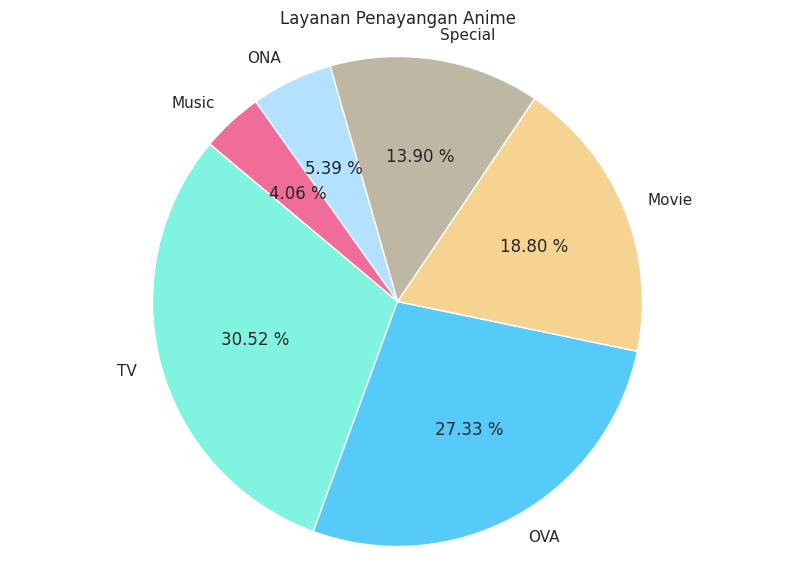

In [25]:
type_counts = anime['type'].value_counts()

labels = type_counts.index.tolist()
sizes = type_counts.values.tolist()

colors = ['#81F4E1', '#56CBF9', '#F5D491', '#BEB7A4', '#B4E1FF', '#F06C9B', '#A3A1FF']

plt.figure(figsize=(10,7))
plt.title('Layanan Penayangan Anime')
plt.pie(sizes, labels=labels, colors=colors[:len(labels)],
        autopct='%.2f %%', startangle=140)
plt.axis('equal')
plt.show()

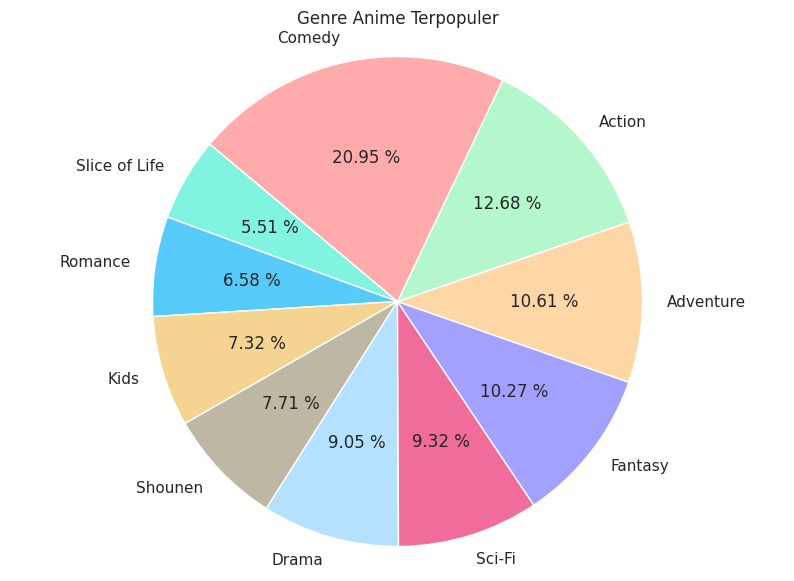

In [26]:
genre_series = anime['genre'].dropna().str.split(', ')
genre_list = [genre for sublist in genre_series for genre in sublist]
genre_counts = Counter(genre_list)

top_genres = dict(genre_counts.most_common(10))
top_genres_sorted = dict(sorted(top_genres.items(), key=lambda item: item[1]))

labels = list(top_genres_sorted.keys())
sizes = list(top_genres_sorted.values())

colors = ['#81F4E1', '#56CBF9', '#F5D491', '#BEB7A4', '#B4E1FF', '#F06C9B', '#A3A1FF', '#FFD6A5', '#B5F7CC', '#FFABAB']

plt.figure(figsize=(10,7))
plt.title('Genre Anime Terpopuler')
plt.pie(sizes, labels=labels, colors=colors[:len(labels)],
        autopct='%.2f %%', startangle=140)
plt.axis('equal')
plt.show()

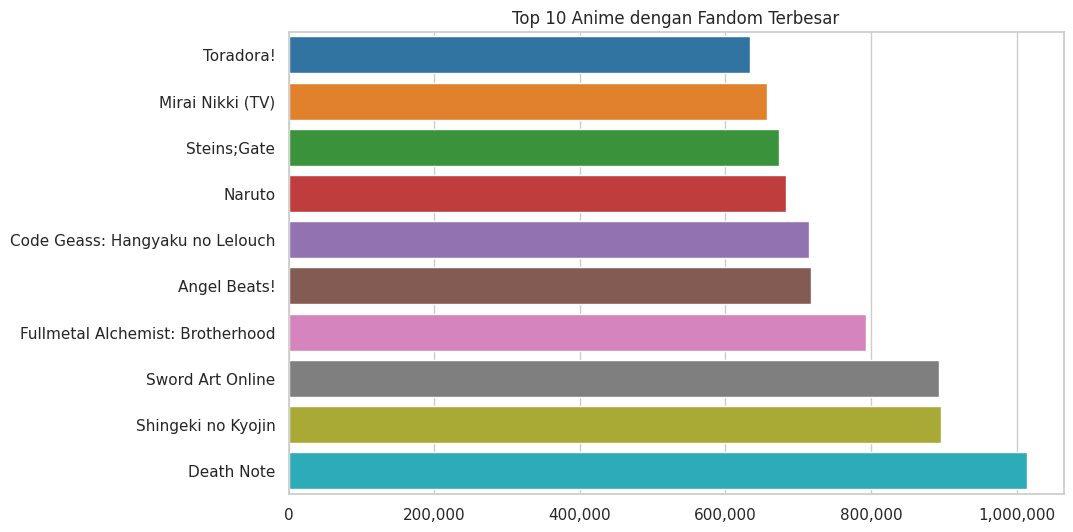

In [27]:
top_community = anime.sort_values(by='members', ascending=False).head(10)
top_community_reversed = top_community[::-1]
unique_colors_community = sns.color_palette("tab10", n_colors=len(top_community_reversed))

plt.figure(figsize=(10,6))
sns.barplot(
    x=top_community_reversed['members'],
    y=top_community_reversed['name'],
    palette=unique_colors_community
)

plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))
plt.title('Top 10 Anime dengan Fandom Terbesar')
plt.xlabel('')
plt.ylabel('')
plt.show()

In [28]:
for index, row in top_community_reversed.iterrows():
    print(f"Anime: {row['name']}, Members: {row['members']:,}")

Anime: Toradora!, Members: 633,817
Anime: Mirai Nikki (TV), Members: 657,190
Anime: Steins;Gate, Members: 673,572
Anime: Naruto, Members: 683,297
Anime: Code Geass: Hangyaku no Lelouch, Members: 715,151
Anime: Angel Beats!, Members: 717,796
Anime: Fullmetal Alchemist: Brotherhood, Members: 793,665
Anime: Sword Art Online, Members: 893,100
Anime: Shingeki no Kyojin, Members: 896,229
Anime: Death Note, Members: 1,013,917


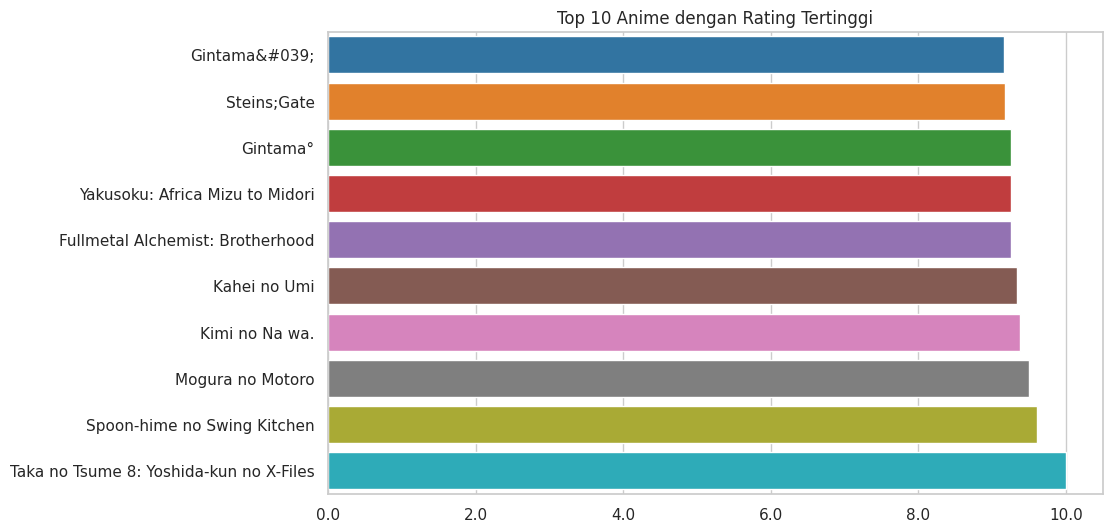

In [29]:
top_rated = anime.sort_values(by='rating', ascending=False).head(10)
top_rated_reversed = top_rated[::-1]
unique_colors_rated = sns.color_palette("tab10", n_colors=len(top_rated_reversed))

plt.figure(figsize=(10,6))
sns.barplot(
    x=top_rated_reversed['rating'],
    y=top_rated_reversed['name'],
    palette=unique_colors_rated
)

plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.1f}'.format(x)))
plt.title('Top 10 Anime dengan Rating Tertinggi')
plt.xlabel('')
plt.ylabel('')
plt.show()

In [30]:
for index, row in top_rated_reversed.iterrows():
    print(f"Anime: {row['name']}, Rating: {row['rating']}")

Anime: Gintama&#039;, Rating: 9.16
Anime: Steins;Gate, Rating: 9.17
Anime: Gintama°, Rating: 9.25
Anime: Yakusoku: Africa Mizu to Midori, Rating: 9.25
Anime: Fullmetal Alchemist: Brotherhood, Rating: 9.26
Anime: Kahei no Umi, Rating: 9.33
Anime: Kimi no Na wa., Rating: 9.37
Anime: Mogura no Motoro, Rating: 9.5
Anime: Spoon-hime no Swing Kitchen, Rating: 9.6
Anime: Taka no Tsume 8: Yoshida-kun no X-Files, Rating: 10.0


# **4. Data Preparation**

Membersihkan simbol menggunakan **regex** pada data (`name`)

In [31]:
def cleaning(txt):
    txt = html.unescape(txt)
    txt = re.sub(r"[^\w\s]", "", txt)
    return txt.strip()

anime['name'] = anime['name'].apply(cleaning)

In [32]:
anime

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,SteinsGate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
...,...,...,...,...,...,...,...
12289,9316,Toushindai My Lover Minami tai MechaMinami,Hentai,OVA,1,4.15,211
12290,5543,Under World,Hentai,OVA,1,4.28,183
12291,5621,Violence Gekiga David no Hoshi,Hentai,OVA,4,4.88,219
12292,6133,Violence Gekiga Shin David no Hoshi Inma Densetsu,Hentai,OVA,1,4.98,175


# **5. Model Development**

In [33]:
devnime = anime[['name', 'genre', 'type', 'episodes']].copy()

In [34]:
devnime

,name,genre,type,episodes
0,Kimi no Na wa,"Drama, Romance, School, Supernatural",Movie,1
1,Fullmetal Alchemist Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64
2,Gintama,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51
3,SteinsGate,"Sci-Fi, Thriller",TV,24
4,Gintama,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51
...,...,...,...,...
12289,Toushindai My Lover Minami tai MechaMinami,Hentai,OVA,1
12290,Under World,Hentai,OVA,1
12291,Violence Gekiga David no Hoshi,Hentai,OVA,4
12292,Violence Gekiga Shin David no Hoshi Inma Densetsu,Hentai,OVA,1


## **Content Based Filtering**

**TF-IDF** (Term Frequency-Inverse Document Frequency)

In [35]:
vct = TfidfVectorizer(stop_words='english')
vct.fit(devnime['genre'])

TfidfVectorizer(stop_words='english')

In [36]:
vct.get_feature_names_out()

array(['action', 'adventure', 'ai', 'arts', 'cars', 'comedy', 'dementia',
       'demons', 'drama', 'ecchi', 'fantasy', 'fi', 'game', 'harem',
       'hentai', 'historical', 'horror', 'josei', 'kids', 'life', 'magic',
       'martial', 'mecha', 'military', 'music', 'mystery', 'parody',
       'police', 'power', 'psychological', 'romance', 'samurai', 'school',
       'sci', 'seinen', 'shoujo', 'shounen', 'slice', 'space', 'sports',
       'super', 'supernatural', 'thriller', 'vampire', 'yaoi', 'yuri'],
      dtype=object)

In [37]:
vct_matrix = vct.fit_transform(devnime['genre'])

vct_matrix.shape

(12017, 46)

In [38]:
vct_matrix.todense()

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.29498527, 0.3162867 , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.2516182 , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [39]:
pd.DataFrame(
    vct_matrix.todense(),
    columns=vct.get_feature_names_out(),
    index=devnime.genre
).sample(22, axis=1).sample(10, axis=0)

,sports,slice,parody,game,yuri,mecha,seinen,demons,dementia,comedy,...,horror,music,josei,historical,ecchi,kids,magic,cars,arts,supernatural
genre,,,,,,,,,,,,,,,,,,,,,
"Adventure, Mecha, Sci-Fi",0.000000,0.000000,0.0,0.0,0.0,0.600987,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
"Action, Adventure, Comedy, Fantasy, Martial Arts, Shounen, Super Power",0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.182726,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.447563,0.000000
"Kids, Romance, School, Shoujo, Slice of Life, Supernatural",0.000000,0.370682,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.338904,0.0,0.0,0.000000,0.391405
"Action, Mecha, Music, Romance, Sci-Fi",0.000000,0.000000,0.0,0.0,0.0,0.470218,0.0,0.0,0.0,0.000000,...,0.0,0.483194,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
Hentai,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
Horror,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,1.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
"Action, Fantasy, Shounen, Supernatural",0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.597693
"Comedy, Drama, Shounen, Sports",0.674204,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.322139,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000
"Action, Adventure, Ecchi, Fantasy",0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.659528,0.000000,0.0,0.0,0.000000,0.000000


**Cosine Similarity**

In [40]:
cs = cosine_similarity(vct_matrix)
cs

array([[1.        , 0.14715318, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.14715318, 1.        , 0.17877808, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.17877808, 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        1.        ],
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        1.        ],
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        1.        ]])

In [41]:
cs_df = pd.DataFrame(cs, index=devnime['name'], columns=devnime['name'])
print('Shape:', cs_df.shape)

cs_df.sample(5, axis=1).sample(5, axis=0)

Shape: (12017, 12017)


name,Suki da yo,Ame to Shoujo to Watashi no Tegami,Shoujo Auction,Tang Lang Bu Chan,Spiral Over
name,,,,,
Junk Story,0.586929,0.0,0.586929,0.000000,0.586929
Teito Monogatari,0.000000,0.0,0.000000,0.546185,0.000000
Namekoke no Ichizoku,0.000000,0.0,0.000000,0.000000,0.000000
Calm,0.000000,0.0,0.000000,0.000000,0.000000
Xiyue Qi Tong,0.000000,0.0,0.000000,0.000000,0.000000


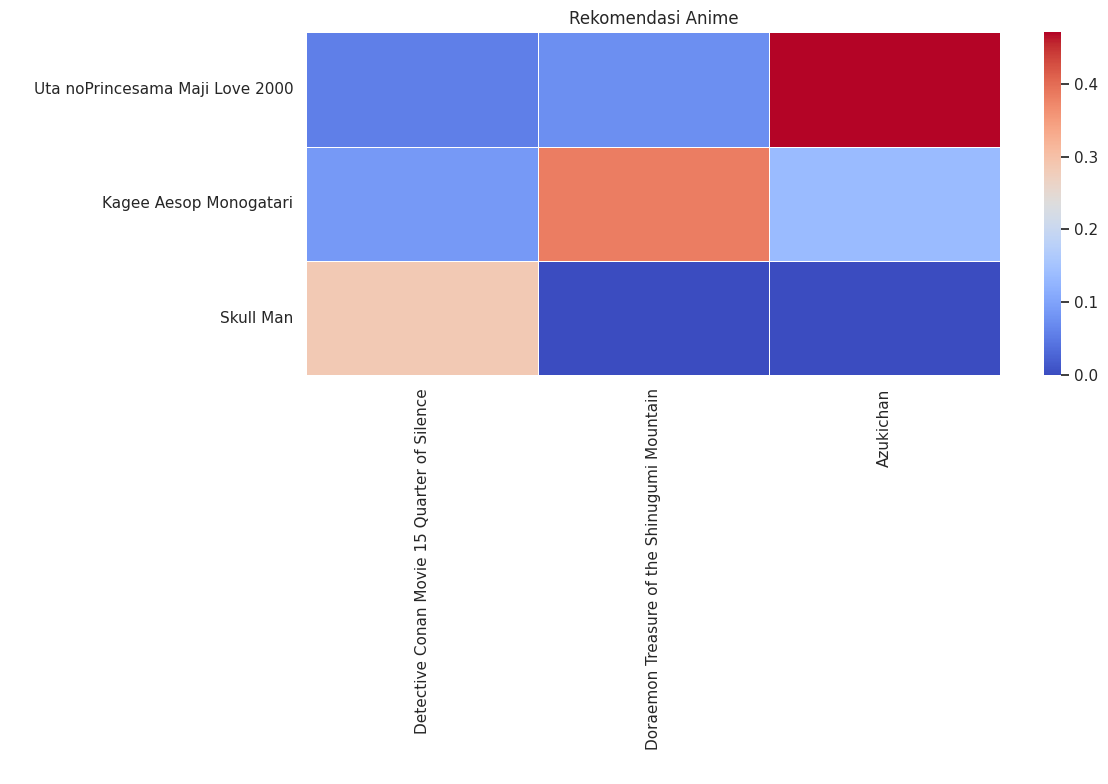

In [64]:
subset = cs_df.sample(3, axis=1).sample(3, axis=0)

plt.figure(figsize=(12, 8))
sns.heatmap(subset, annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("Rekomendasi Anime")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.xlabel(' ')
plt.ylabel(' ')
plt.show()

In [43]:
def recommend_anime(title, similarity_data=cs_df, items=devnime[['name', 'genre']], k=5):
    if title not in similarity_data.columns:
        return f"Anime '{title}' tidak ditemukan dalam data."

    idx = similarity_data[title].to_numpy().argpartition(range(-1, -k-1, -1))
    similar_animes = similarity_data.columns[idx[-1:-(k+2):-1]]
    similar_animes = similar_animes.drop(title, errors='ignore')

    return pd.DataFrame(similar_animes, columns=['name']).merge(items, on='name').head(k)

In [44]:
devnime[devnime.name.eq('Naruto')]

,name,genre,type,episodes
841,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220


In [45]:
recommend_anime('Naruto')

,name,genre
0,Naruto Shippuuden Sunny Side Battle,"Action, Comedy, Martial Arts, Shounen, Super P..."
1,Boruto Naruto the Movie Naruto ga Hokage ni N...,"Action, Comedy, Martial Arts, Shounen, Super P..."
2,Naruto Shippuuden Movie 3 Hi no Ishi wo Tsugu...,"Action, Comedy, Martial Arts, Shounen, Super P..."
3,Naruto Soyokazeden Movie Naruto to Mashin to M...,"Action, Comedy, Martial Arts, Shounen, Super P..."
4,Naruto Shippuuden Movie 4 The Lost Tower,"Action, Comedy, Martial Arts, Shounen, Super P..."


In [46]:
recommend_anime('Bungou Stray Dogs')

,name,genre
0,Bungou Stray Dogs 2nd Season,"Mystery, Seinen, Supernatural"
1,Baccano Specials,"Action, Comedy, Historical, Mystery, Seinen, S..."
2,Baccano,"Action, Comedy, Historical, Mystery, Seinen, S..."
3,Urban Square Kouhaku no Tsuigeki,"Action, Mystery, Seinen"
4,Kara no Kyoukai Mirai Fukuin,"Drama, Mystery, Seinen, Supernatural"


## **Collaborative Filtering**

**K-Nearest Neighbor** (KNN) Method

In [47]:
aniname = pd.DataFrame({'Nama Anime': anime['name']})

print(aniname.head())

                        Nama Anime
0                    Kimi no Na wa
1  Fullmetal Alchemist Brotherhood
2                          Gintama
3                       SteinsGate
4                          Gintama


In [48]:
anime.set_index('name', inplace=True)

In [49]:
anime_ngb = anime[['rating','type']]

In [50]:
anew = pd.get_dummies(anime_ngb[['type']])
anew = pd.concat([anime_ngb, anew], axis=1)
anew = anew.drop(columns='type')

anew.head()

,rating,type_Movie,type_Music,type_ONA,type_OVA,type_Special,type_TV
name,,,,,,,
Kimi no Na wa,9.37,True,False,False,False,False,False
Fullmetal Alchemist Brotherhood,9.26,False,False,False,False,False,True
Gintama,9.25,False,False,False,False,False,True
SteinsGate,9.17,False,False,False,False,False,True
Gintama,9.16,False,False,False,False,False,True


In [51]:
knn = NearestNeighbors(metric='euclidean')
knn.fit(anew)

NearestNeighbors(metric='euclidean')

In [52]:
def recommend_nimek(anime_name: str, recommend_anime: int = 10):
    if anime_name not in anew.index:
        return f"Anime '{anime_name}' tidak ditemukan dalam data."

    print(f'Berdasarkan preferensimu terhadap anime: {anime_name}\nBerikut beberapa rekomendasi yang serupa:')

    distances, neighbors = knn.kneighbors(anew.loc[[anime_name]], n_neighbors=recommend_anime)
    similar_anime = anew.iloc[neighbors[0]].index.tolist()
    similar_distance = [f"{round(100 - distance, 2)}%" for distance in distances[0]]

    return pd.DataFrame({
        "Anime Name": similar_anime,
        "Similarity Score": similar_distance
    })

In [53]:
recommend_nimek('Shigatsu wa Kimi no Uso')

Berdasarkan preferensimu terhadap anime: Shigatsu wa Kimi no Uso
Berikut beberapa rekomendasi yang serupa:


,Anime Name,Similarity Score
0,Shigatsu wa Kimi no Uso,100.0%
1,Haikyuu Second Season,99.99%
2,Mushishi Zoku Shou 2nd Season,99.96%
3,Code Geass Hangyaku no Lelouch R2,99.94%
4,Hajime no Ippo,99.91%
5,Code Geass Hangyaku no Lelouch,99.91%
6,Cowboy Bebop,99.9%
7,One Punch Man,99.9%
8,Monogatari Series Second Season,99.88%
9,Mushishi Zoku Shou,99.88%


In [54]:
recommend_nimek('Kimi no Na wa')

Berdasarkan preferensimu terhadap anime: Kimi no Na wa
Berikut beberapa rekomendasi yang serupa:


,Anime Name,Similarity Score
0,Kimi no Na wa,100.0%
1,Kahei no Umi,99.96%
2,Mogura no Motoro,99.87%
3,Gintama Movie Kanketsuhen Yorozuya yo Eien Nare,99.73%
4,Koe no Katachi,99.68%
5,Shenmi Shijie Lixian Ji,99.63%
6,Okaachan Gomen ne,99.63%
7,Mirai ni Mukete Bousai wo Kangaeru,99.63%
8,Shaka no Shougai,99.63%
9,Sen to Chihiro no Kamikakushi,99.56%


# **6. Evaluasi**

**Davies-Bouldin** mengukur seberapa baik cluster dalam dataset, dan semakin rendah skor tersebut, semakin baik kualitas clustering yang dihasilkan. Skor yang lebih rendah menunjukkan bahwa cluster lebih terpisah dan lebih rapat satu sama lain.

In [55]:
dbs = davies_bouldin_score(anew, aniname)
print(f"Davies-Bouldin: {dbs}")

Davies-Bouldin: 1.7372932679932307


**Calinski-Harabasz** juga dikenal sebagai Variance Ratio Criterion, adalah salah satu metrik evaluasi untuk mengukur kualitas hasil clustering.

In [56]:
ch = calinski_harabasz_score(anew, aniname)
print("Calinski-Harabasz: ", ch)

Calinski-Harabasz:  5.687692131433239
